The Goal : take the previous notebook foundation and scale up the implemetaion to functional implemetaion allowing deeper

In [24]:
import cupy as cp 

x = cp.array([[1, 2, 3],
            [4, 5, 6],
            [7, 8, 9],
            [10, 11, 12]])

y = cp.array([1,0,0, 1])

print(x.shape)
print(y.shape)


(4, 3)
(4,)


In [3]:
# first builkding the functions for the activations and thier derivatives

def relu(x):
    return cp.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + cp.exp(-x))

def back_relu(x):
    return cp.where(x >= 0, 1, 0)

def back_sigmoid(x):
    return x * (1 - x)

def tanh(x):
    return cp.tanh(x)

def back_tanh(x):
    return 1 - cp.tanh(x)**2

def softmax(x):
    return cp.exp(x) / cp.sum(cp.exp(x), axis=1, keepdims=True) 

def back_softmax(x):
    return cp.exp(x) / cp.sum(cp.exp(x), axis=1, keepdims=True)


In [7]:
# lets test them 

print(relu(x))

print(sigmoid(x))

print(back_relu(x))

print(back_sigmoid(x))

print(tanh(x))

print(back_tanh(x))

print(softmax(x))

print(back_softmax(x))

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[0.73105858 0.88079708 0.95257413]
 [0.98201379 0.99330715 0.99752738]
 [0.99908895 0.99966465 0.99987661]]
[[1 1 1]
 [1 1 1]
 [1 1 1]]
[[  0  -2  -6]
 [-12 -20 -30]
 [-42 -56 -72]]
[[0.76159416 0.96402758 0.99505475]
 [0.9993293  0.9999092  0.99998771]
 [0.99999834 0.99999977 0.99999997]]
[[4.19974342e-01 7.06508249e-02 9.86603717e-03]
 [1.34095068e-03 1.81583231e-04 2.45765474e-05]
 [3.32610934e-06 4.50140598e-07 6.09199171e-08]]
[[0.09003057 0.24472847 0.66524096]
 [0.09003057 0.24472847 0.66524096]
 [0.09003057 0.24472847 0.66524096]]
[[0.09003057 0.24472847 0.66524096]
 [0.09003057 0.24472847 0.66524096]
 [0.09003057 0.24472847 0.66524096]]


In [53]:
## next we must calculate the loss and its derivative

def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-15
    y_pred = cp.clip(y_pred, epsilon, 1 - epsilon)
    loss = -cp.mean(y_true * cp.log(y_pred) + (1 - y_true) * cp.log(1 - y_pred))
    return loss

## we will use binary cross entropy loss function , again becuse this is a binary classification problem

def binary_cross_entropy_derivative(y_true, y_pred):
    epsilon = 1e-15
    y_pred = cp.clip(y_pred, epsilon, 1 - epsilon)
    return (y_pred - y_true)

def cross_entropy(y_true, y_pred):
    epsilon = 1e-15
    y_pred = cp.clip(y_pred, epsilon, 1 - epsilon)
    loss = -cp.mean(y_true * cp.log(y_pred))
    return loss

def cross_entropy_derivative(y_true, y_pred):
    epsilon = 1e-15
    y_pred = cp.clip(y_pred, epsilon, 1 - epsilon)
    return (y_pred - y_true)


In [49]:
def initilaize_params(layer_dim, init_type='he'):
    params = {}
    L = len(layer_dim)

    for l in range(1, L):
        curr = layer_dim[l]
        prev = layer_dim[l - 1]

        if init_type == "he":
            params[f'W{l}'] = cp.random.randn(prev, curr) * cp.sqrt(2. / prev)  # Corrected this line
        elif init_type == "xavier":
            params[f'W{l}'] = cp.random.randn(prev, curr) * cp.sqrt(2. / (prev + curr))
        else:
            params[f'W{l}'] = cp.random.randn(prev, curr)
        
        params[f'b{l}'] = cp.zeros((1,curr))  # Shape should be (curr, 1) for each bias vector

    return params

# Test the initialization process
layer_dim = [3, 4, 5, 2]
params = initilaize_params(layer_dim)

# Print parameter shapes
print("Parameters:")
print(params)
for key, value in params.items():
    print(f"{key}: {value.shape}")


Parameters:
{'W1': array([[ 0.40261336, -0.42279753, -1.62350904, -1.78606239],
       [-0.77602123, -0.26883827, -0.28069636,  0.6815862 ],
       [-0.31999834,  1.02323851,  1.5092853 ,  0.3360027 ]]), 'b1': array([[0., 0., 0., 0.]]), 'W2': array([[-0.69923748,  0.92207724,  1.05543581,  2.11267069, -0.36197983],
       [-0.11419795,  0.29227224,  0.61537126,  0.19573   ,  0.88028918],
       [ 0.8263951 ,  0.06764375,  1.53412465,  0.50726356, -1.19418482],
       [ 0.64146579, -0.9736837 , -0.1913005 ,  0.69026047,  0.23910163]]), 'b2': array([[0., 0., 0., 0., 0.]]), 'W3': array([[-0.39920559, -0.17391365],
       [-0.70038979,  0.09294245],
       [ 0.40635658,  0.17609945],
       [-0.44561863,  0.72264408],
       [ 0.25365797,  0.40126846]]), 'b3': array([[0., 0.]])}
W1: (3, 4)
b1: (1, 4)
W2: (4, 5)
b2: (1, 5)
W3: (5, 2)
b3: (1, 2)


In [54]:
def forward(X, params, activation=['relu', 'sigmoid']):
    L = len(params) // 2  # Number of layers
    A = X

    activation_functions = {'relu': relu, 'sigmoid': sigmoid, 'tanh': tanh}  # Added 'tanh'
    A_dict = {0: X}
    Z_dict = {}

    for l in range(1, L + 1):
        W = params[f'W{l}']
        b = params[f'b{l}']
        Z = cp.dot(A, W) + b # Ensure b is transposed to match dimensions
        activation_func = activation[l - 1] if l - 1 < len(activation) else activation[-1]
        A = activation_functions[activation_func](Z)
        A_dict[l] = A
        Z_dict[l] = Z

    return A, Z, A_dict, Z_dict


layer_dim = [3, 4, 5, 2,1]
params = initilaize_params(layer_dim)
X = cp.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])
y = cp.array([1, 0, 0, 1])

A, Z, A_dict, Z_dict = forward(X, params)

print("Forward Pass:")
print("A:", A)
print("Z:", Z)
print("A_dict:", A_dict)
print("Z_dict:", Z_dict)

Forward Pass:
A: [[0.26389164]
 [0.26389164]
 [0.26389164]
 [0.26389164]]
Z: [[-1.02583876]
 [-1.02583876]
 [-1.02583876]
 [-1.02583876]]
A_dict: {0: array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]]), 1: array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), 2: array([[0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5]]), 3: array([[0.5965426 , 0.38553746],
       [0.5965426 , 0.38553746],
       [0.5965426 , 0.38553746],
       [0.5965426 , 0.38553746]]), 4: array([[0.26389164],
       [0.26389164],
       [0.26389164],
       [0.26389164]])}
Z_dict: {1: array([[ -6.18266689,  -2.48656611,  -3.37880516,  -1.85612376],
       [-13.53614547,  -6.45106519,  -4.79610369,  -5.58146141],
       [-20.88962404, -10.41556428,  -6.21340222,  -9.30679906],
       [-28.24310261, -14.38006337,  -7.63070075, -13.03213672]]), 2: array([[0., 0.,

In [55]:
def backward(X, y, params, activation=['relu', 'sigmoid'], learning_rate=0.01):
    L = len(params) // 2  # Number of layers
    m = X.shape[0]  # Number of training examples

    # Forward pass to get activations and pre-activations
    _, _, A_dict, Z_dict = forward(X, params, activation)
    A = A_dict
    Z = Z_dict

    # Initialize gradients
    dW = {}
    db = {}

    # Output layer gradient
    dZ = A[L] - y.reshape(-1, 1)  # Ensure y is correctly shaped
    dW[L] = cp.dot(A[L - 1].T, dZ) / m
    db[L] = cp.sum(dZ, axis=0, keepdims=True) / m

    # Backpropagate through hidden layers
    for l in range(L - 1, 0, -1):
        # Determine activation function
        activation_func = activation[l - 1] if (l - 1) < len(activation) else activation[-1]
        # Compute derivative based on activation
        if activation_func == 'relu':
            derivative = back_relu(Z[l])
        elif activation_func == 'sigmoid':
            derivative = back_sigmoid(A[l])
        else:
            raise ValueError(f"Unsupported activation function: {activation_func}")

        dZ = cp.dot(dZ, params[f'W{l + 1}'].T) * derivative
        dW[l] = cp.dot(A[l - 1].T, dZ) / m
        db[l] = cp.sum(dZ, axis=0, keepdims=True) / m

    # Update parameters
    for l in range(1, L + 1):
        params[f'W{l}'] -= learning_rate * dW[l]
        params[f'b{l}'] -= learning_rate * db[l]

    return params

In [57]:

def train(X, y, params, activation=['relu', 'sigmoid'], learning_rate=0.01, epochs=1000, verbose=True):
    loss_history = []
    for epoch in range(epochs):
        params = backward(X, y, params, activation, learning_rate)
        y_pred, _, _, _ = forward(X, params, activation)
        loss = binary_cross_entropy(y.reshape(-1, 1), y_pred)
        loss_history.append(loss)
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss:.4f}")

    return params, loss_history

In [73]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss(loss_history):
    # Check if loss_history is a CuPy array (whether it's a single CuPy array or inside a list)
    if isinstance(loss_history, list):
        loss_history = [loss.get() if isinstance(loss, cp.ndarray) else loss for loss in loss_history]
        loss_history = np.array(loss_history)  # Convert list to NumPy array
    elif isinstance(loss_history, cp.ndarray):
        loss_history = loss_history.get()  # Convert CuPy array to NumPy array
    
    # Plot the loss history (Now it should be a NumPy array or list)
    plt.plot(loss_history)
    plt.title("Loss over training epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()



def predict(X, params):
    _, _, A_dict, _ = forward(X, params)
    return A_dict


Epoch 1/1000 - Loss: 0.8898
Epoch 101/1000 - Loss: 0.7243
Epoch 201/1000 - Loss: 0.6981
Epoch 301/1000 - Loss: 0.6940
Epoch 401/1000 - Loss: 0.6932
Epoch 501/1000 - Loss: 0.6931
Epoch 601/1000 - Loss: 0.6931
Epoch 701/1000 - Loss: 0.6931
Epoch 801/1000 - Loss: 0.6931
Epoch 901/1000 - Loss: 0.6930


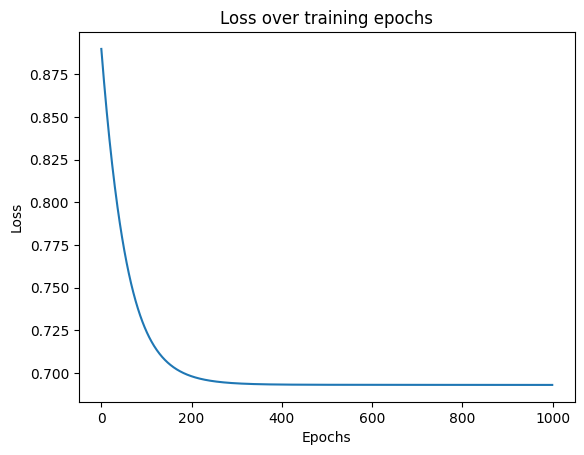

Predictions on new data: {0: array([[1, 2, 3],
       [4, 5, 6]]), 1: array([[0.        , 2.00375861, 0.        , 0.        ],
       [0.        , 2.22804087, 0.        , 0.        ]]), 2: array([[0.85459626, 0.14510167, 0.76889108, 0.88954865, 0.44278053],
       [0.87772646, 0.12226942, 0.79225417, 0.91043785, 0.43662134]]), 3: array([[0.49887582],
       [0.49933595]])}


In [74]:
# Initialize parameters and train the model
params = initilaize_params([3, 4, 5,1])  # Layer sizes: 3 inputs, 4 hidden neurons, 1 output
final_params, loss_history = train(X, y, params, activation=['relu', 'sigmoid'], learning_rate=0.01, epochs=1000)

# Plot the loss history
plot_loss(loss_history)

# Test predictions
X_test = cp.array([[1, 2, 3], [4, 5, 6]])
predictions = predict(X_test, final_params)
print("Predictions on new data:", predictions)

Lets scale up 